## Basic usage

In this section, the essential settings to run a ReMeta analysis are introduced.

First some essential imports:

In [23]:
import numpy as np
import remeta
np.random.seed(1)  # make notebook reproducible
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Basic model specification
In a first step, we specify the basic nature of the computational model. First, we assumes that the dominant source of metacognitive noise occurs at the stage of the metacognitive readout of type 1 decision values (`meta_noise_type='noisy-readout'`). Second, we assume that metacognitive noise can be described by a censored normal distribution (`meta_noise_model='censored_norm'`). And third, we assume that our hypothetical observer aims at reporting probability correct (`meta_link_function='probability_correct'`).

In [24]:
options_basic = dict(
    meta_link_function='probability_correct',
    meta_noise_type='noisy_report',
    meta_noise_model='beta'
)

#### Parameter specification
In a next step, we specify the parameters to be included in the generative model. By default, a parametery for sensory noise and metacognitive noise is enabled, as well as parameters for a sensory bias and a confidence slope. Check out the `configuration.py` module for the `enable_XYZ` keywords. Each parameter can either be disabled (`enable_XYZ=0`), enabled (`enable_XYZ=1`) or enabled in duplex mode (`enable_XYZ=2`), which means that separate values are fitted depending on the sign of the stimulus (for sensory parameters) or the sign of the sensory decision value (for metacognitive parameters).

Here, we slightly deviate from the defaults by additionally enabling separate noise parameters for both stimulus categories (i.e. `enable_noise_sens=2`), as well as by including a metacognitive readout term (`enable_readout_term_meta=True`). For completeness, we define all available enable_XYZ keywords below, although it suffices to define the ones that differ from the default settings.

In [25]:
options_enable = dict(
    enable_warping_sens=0,
    enable_noise_sens=2,  # default 1
    enable_noise_multi_sens=0,
    enable_thresh_sens=0,
    enable_bias_sens=1,
    enable_noise_meta=1,
    enable_noise_multi_meta=0,
    enable_readout_term_meta=1,  # default 0
    enable_slope_meta=1,
    enable_scaling_meta=0,
    enable_criteria_meta=0,
    enable_levels_meta=0
)

Based on these settings we can create a configuration object:

In [26]:
cfg = remeta.Configuration(**options_basic, **options_enable)

#### Sample from the generative model
To test the model, we generate data based on the generative model outlined above. To this aim, we have to define _specific_ values for each parameter.

In [27]:
params = dict(
    noise_sens=[0.3, 0.4],
    bias_sens=-0.1,
    noise_meta=0.2,
    readout_term_meta=-0.1,
    slope_meta=1.4,
)

Note that we defined `noise_sens` as a vector, such that `noise_sens[0]` and `noise_sens[1]` correspond to the sensory noise for the negative and positive stimulus category, respectively.

We generate 2000 samples for a single participant. The option `stimulus_stepsize` creates stimuli between `stimulus_stepsize` and 1 in steps of `stimulus_stepsize` (i.e., for a setting of 0.25, there are four different intensities: 0.25, 0.5 0.75, 1).

In [28]:
data = remeta.simu_data(nsubjects=1, nsamples=2000, params=params, squeeze=True, stimuli_stepsize=0.25, cfg=cfg)

----------------------------------
Basic stats of the simulated data:
    Performance: 92.0% correct
    Confidence: 0.67 ± 0.01
    Choice bias: +2.6%
    AUROC2: 0.76
----------------------------------


#### Visualizing the simulated data

Let's take a look at the psychometric curve:

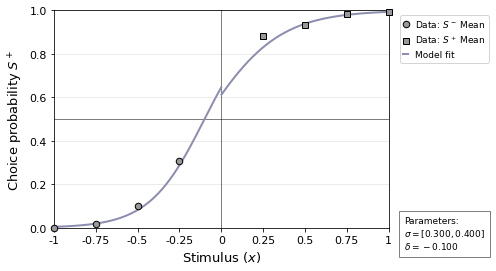

In [29]:
remeta.plot_psychometric(cfg, data.choices, data.stimuli, data.params_sens);

Note that the purple line is not a fit, but a logistic function based on the true parameters. At zero, there is a discontinuity due the different noise parameters for stimulus>0 and stimulus<0. Moreover, the curve is shifted to the left due to the negative bias parameter.

Next, we plot the relationship between stimulus intensity and confidence:

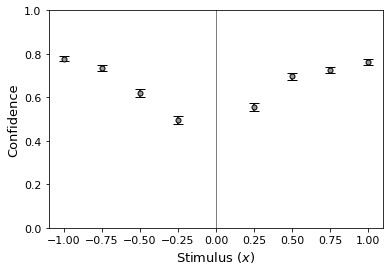

In [30]:
remeta.plot_confidence(data.stimuli, data.confidence);

We can see that the confidence slope for negative stimuli is a bit steeper. This is because we had introduced an assymmetry in the type 1 noise between the positive and the negative stimulus category. Since we further assume an observer that reports probability correct based on an estimate of type 1 noise, confidence appears more 'sensitive' for the negative stimulus category (remember that we set _lower_ type 1 noise for stimulus<0 relative to stimulus>0).

#### Model fit
We now need to create an instance of ReMeta. We pass the true parameters to the configuration as well, which is of course only possible with simulated data. We'll come back to this later.

In [31]:
cfg.true_params = params
rem = remeta.ReMeta(cfg=cfg)
# Note we could have initialized the class also without creating the configuration instance:
# rem = remeta.ReMeta(true_params=params, **options_basic, **options_enable)

Now, everything is in place to fit the model to the simulated data:

In [32]:
rem.fit(data.stimuli, data.choices, data.confidence, verbose=True)


+++ Sensory component +++
Initial neg. LL: 1016.59
    [initial] noise_sens_0: 0.1
    [initial] noise_sens_1: 0.1
    [initial] bias_sens: 0
Performing local optimization
    [final] noise_sens: [0.273, 0.403] (true: [0.300, 0.400])
    [final] bias_sens: -0.141 (true: -0.100)
Final neg. LL: 444.96
Neg. LL using true params: 446.73
Stats: 0.60 secs, 444 fevs

+++ Metacognitive component +++
Initial neg. LL: 12396.19
    [initial] noise_meta: 0.2
    [initial] readout_term_meta: 0
    [initial] slope_meta: 1
Grid search activated (grid size = 300)
    [grid] noise_meta: 0.25
    [grid] readout_term_meta: -0.1
    [grid] slope_meta: 1.7
Grid neg. LL: 12362.7
Grid stats: 55.99 secs
Performing local optimization
    [final] noise_meta: 0.231 (true: 0.200)
    [final] readout_term_meta: -0.119 (true: -0.100)
    [final] slope_meta: 1.956 (true: 1.400)
Final neg. LL: 12355.26
Neg. LL using true params: 12365.73
Stats: 13.59 secs, 97 fevs


Obtain the fitting result:

In [33]:
result = rem.summary(extended=True)

Through the setting `extended=True`, the result object additionally contains a number of latent model variables (which take up quite some space, hence optional).

#### Inspecting the model fit

The parameters are stored in the attribute `model`. We've seen the estimated parameters already printed above, but they are also stored in the result object:

In [34]:
print(result.model.params_sens)


{'noise_sens': [0.2728292024609163, 0.40327027769008217], 'bias_sens': -0.14133024191629398}


Given that the original parameter were `noise_sens=[0.3, 0.4]` and `bias_sens=-0.1`, this is not too bad. We have recovered the original parameters to some approximation. Nevertheless, the fitted parameters do not _exactly_ match our generative parameters. Since we passed the true parameters, the result object allows us to check whether this is because the optimization routine did not find the global minimum or whether the imprecision is in the data itself. Specifically, the result object contains both the likelihood of the fitted parameters and the likelihood of the true parameters:

In [35]:
print(f'Negative log-likelihood of true sensory parameters: {result.model.fit.fit_sens.negll_true:.1f}')
print(f'Negative log-likelihood of fitted sensory  parameters: {result.model.fit.fit_sens.negll:.1f}')

Negative log-likelihood of true sensory parameters: 446.7
Negative log-likelihood of fitted sensory  parameters: 445.0


The negative log-likelihood is smaller for the fitted parameters, i.e. the likelihood is higher for the fitted than the true parameters. We can thus be confident in the obtained parameters.

Next, we take a look at the metacognitive parameters:

In [36]:
print(result.model.params_meta)


{'noise_meta': 0.23122399581639186, 'readout_term_meta': -0.11850102857601251, 'slope_meta': 1.9555948902758504}


In [37]:
print(f'Negative log-likelihood of true metacognitive parameters: {result.model.fit.fit_meta.negll_true:.1f}')
print(f'Negative log-likelihood of fitted metacognitive parameters: {result.model.fit.fit_meta.negll:.1f}')

Negative log-likelihood of true metacognitive parameters: 12365.7
Negative log-likelihood of fitted metacognitive parameters: 12355.3


Similar story! The recovered parameters are similar to the true parameters and the likelihhod is better for the fitted parameters.

Using the model fit, we can now visualize confidence (based on the data and the fitted model) as a function of model-predicted sensory decision values:

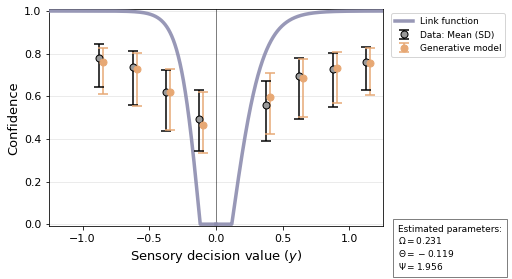

In [38]:
remeta.plot_link_function(
    cfg, data.stimuli, data.confidence, result.model.extended.dv_sens_mode, result.model.params_sens,
    result.model.params_meta
);

The large overlap between data- and model-based confidence ratings is of course not surprising, since the data were generated with a model of identical architecture and similar parameters. Overlayed in purple is the link function that maps type 1 decision values to confidence.

In [39]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 5))
# remeta.plot_confidence_dist(
#     cfg, data.stimuli, data.confidence, result.model.params_sens, result.model.params_meta,
#     var_likelihood=result.model.extended.confidence, noise_meta_transformed=result.model.extended.noise_meta,
#     dv_sens=result.model.extended.dv_sens, likelihood_weighting=result.model.extended.dv_sens_pmf
# );